In [51]:
import helpFunctions as hf 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread
import scipy as sp
import os

Load Data

In [52]:
# Folder where your data files are placed
dirIn = r'C:\Users\suzan\OneDrive\School\DTU\Semester 4\Mathematical Modeling\Exercise 1\Salami\data'

matFile = os.path.join(dirIn, 'multispectral_day01.mat')
annFile = os.path.join(dirIn, 'annotation_day01.png')

# Load multispectral image and annotation using your original helpFunctions
multiIm, annotationIm = hf.loadMulti(matFile, annFile)

## The function getPix extracts the multi spectral pixels from the annotation
# Here is an example with meat- and fat annotation
[fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
[meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);

# load non-annotated pixels to be classified
[bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

1. Threshold value for a single spectral band

In [53]:
mean_fat = np.mean(fatPix,0)
mean_meat = np.mean(meatPix,0)

var_fat = np.var(fatPix, 0)
var_meat = np.var(meatPix, 0)

t_list = []
errors = []

for i in range(19):
    t = (mean_fat[i] + mean_meat[i])/2
    t_list.append(t)

    n_fat = fatPix.shape[0]
    n_meat = meatPix.shape[0]

    fat_errors = np.sum(fatPix[:, i] < t)
    meat_errors = np.sum(meatPix[:, i] >= t)

    error = (fat_errors + meat_errors) / (n_fat + n_meat)
    errors.append(error)
    #print(f"Spectral Band: {i+1}, t = {t}, error = {error}")

min_error = np.min(errors)
index = errors.index(min_error)
print(f"Spectral Band: {index+1}, t = {t_list[index]: .3}, error = {min_error: .3}")

Spectral Band: 14, t =  69.0, error =  0.00464


In [54]:
'''
## Show image óf spectral band with lowest error
plt.imshow(multiIm[:,:,index])
plt.title(f"Spectral Band: {index+1}")
plt.show()

## In each layer we have a binary image:
# 0 - background with salami
# 1 fat annotation
# 2 meat annotation

# Here we show the far annotation
plt.imshow(annotationIm[:,:,1])
plt.title("Fat Annotations")
plt.show()

# Here we show the meat annotation
plt.imshow(annotationIm[:,:,2])
plt.title("Meat Annotations")
plt.show()

annotationIm[:,:,2].shape
'''

'\n## Show image óf spectral band with lowest error\nplt.imshow(multiIm[:,:,index])\nplt.title(f"Spectral Band: {index+1}")\nplt.show()\n\n## In each layer we have a binary image:\n# 0 - background with salami\n# 1 fat annotation\n# 2 meat annotation\n\n# Here we show the far annotation\nplt.imshow(annotationIm[:,:,1])\nplt.title("Fat Annotations")\nplt.show()\n\n# Here we show the meat annotation\nplt.imshow(annotationIm[:,:,2])\nplt.title("Meat Annotations")\nplt.show()\n\nannotationIm[:,:,2].shape\n'

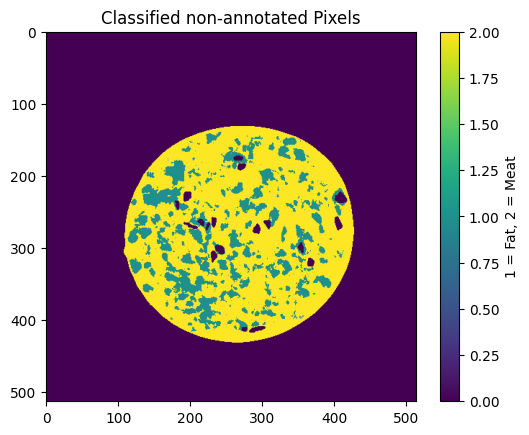

In [55]:
bgPix_14 = bgPix[:, index] # pixels spectral band 14

# 1 = fat, 2 = meat
classified = np.zeros(annotationIm.shape[:2], dtype=np.uint8)

for i in range(bgPix_14.shape[0]):
    r = bgR[i]
    c = bgC[i]

    if bgPix_14[i] > t_list[index]:
        classified[r, c] = 1  # fat
    else:
        classified[r, c] = 2  # meat

plt.imshow(classified)
plt.title("Classified non-annotated Pixels")
plt.colorbar(label="1 = Fat, 2 = Meat")
plt.show()

2. Classification by means of all spectral band

In [56]:
# Covariance
cov_fat = np.cov(fatPix, rowvar=False)
cov_meat = np.cov(meatPix, rowvar=False)

# Number of fat and meat pixels
nf = np.shape(fatPix)[0]
nm = np.shape(meatPix)[0]

# Pooler Covariance - equation 20
pooled_cov = ((nf-1)*cov_fat + (nm-1)*cov_meat)/((nf-1)+(nm-1))

# Discriminant Function - equation 23
p_fat = nf / (nf + nm)
p_meat = nm / (nf + nm)
cov_inv = np.linalg.inv(pooled_cov)

# fat pixels
Sff = fatPix @ cov_inv @ mean_fat  - 0.5 * mean_fat  @ cov_inv @ mean_fat  + np.log(p_fat)
Sfm = fatPix @ cov_inv @ mean_meat - 0.5 * mean_meat @ cov_inv @ mean_meat + np.log(p_meat)

# meat pixels
Smf = meatPix @ cov_inv @ mean_fat  - 0.5 * mean_fat  @ cov_inv @ mean_fat  + np.log(p_fat)
Smm = meatPix @ cov_inv @ mean_meat - 0.5 * mean_meat @ cov_inv @ mean_meat + np.log(p_meat)

# Error rate
fat_errors  = np.sum(Sff < Sfm)
meat_errors = np.sum(Smm < Smf)

error = (fat_errors + meat_errors) / (nf + nm)
print(f"Error rate = {error: .3}")

Error rate =  0.0058


In [ ]:
# load non-annotated pixels to be classified
[bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

3. Calculation for all days